# Data Retrieval

In [88]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

def data_retrieval(filepath):
    df = pd.read_csv(filepath)
    return df

df = data_retrieval('gutenberg_expanded.csv')
print(df)

       Unnamed: 0   author  label  \
0               0   austen      0   
1               1   austen      0   
2               2   austen      0   
3               3   austen      0   
4               4   austen      0   
...           ...      ...    ...   
18888       18888  whitman     11   
18889       18889  whitman     11   
18890       18890  whitman     11   
18891       18891  whitman     11   
18892       18892  whitman     11   

                                                    text  
0      [Emma Jane Austen 1816] VOLUME I CHAPTER I Emm...  
1      Even Miss Taylor ceased hold nominal office go...  
2      It wedding-day beloved friend Emma sat mournfu...  
3      The want Miss Taylor felt hour day.She recalle...  
4      She dearly loved father, companion her.He meet...  
...                                                  ...  
18888  Mirages More experiences sights, stranger, you...  
18889  The Unexpress'd How dare it?After cycles, poem...  
18890  More evolutionary

# Data Analysis

In [24]:
import numpy as np
# determining average word count per text
word_count = []
for i in df['text'].values:
    word_count.append(len(i.split()))
word_count = np.array(word_count)

In [25]:
def get_stats(var):
    """Print summary statistics for a variable of interest.
    
    Args:
    var: array. Numpy array containing values for the variable of interest.

    Returns:
    None
    """
    print("Min:", np.min(var))
    print("Max:", np.max(var))
    print("Mean:", np.mean(var))
    print("Median", np.median(var))
    print("1st percentile", np.percentile(var, 1))
    print("95th percentile", np.percentile(var, 95))
    print("99th percentile", np.percentile(var, 99))
    print("99.5th Percentile", np.percentile(var, 99.5))
    print("99.9th Percentile", np.percentile(var, 99.9))

In [26]:
print("Word count statistics")
get_stats(word_count)

Word count statistics
Min: 5
Max: 814
Mean: 53.38819595562868
Median 48.0
1st percentile 14.0
95th percentile 102.0
99th percentile 154.0
99.5th Percentile 178.0
99.9th Percentile 250.48000000001048


/Users/gracekim/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists w

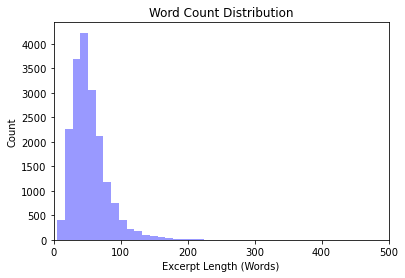

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
# Plot word count distribution
sns.distplot(word_count, kde = False, bins = 70, color = 'blue').set_title("Word Count Distribution")
plt.xlabel('Excerpt Length (Words)')
plt.ylabel('Count')
plt.xlim(0, 500)
plt.savefig("word_count.eps")

# Splitting the Data

In [89]:
from sklearn.model_selection import train_test_split
text = df['text'].values
labels = df['label'].values
# splitting data into 80-20 for training and testing
text_train, text_test_val, label_train, label_test_val = train_test_split(text,labels, test_size = 0.2, random_state = 42)
# splitting testing data into 50-50 for testing and validation
text_test, text_val, label_test, label_val = train_test_split(text_test_val, label_test_val, test_size=.5, random_state=42)
print(text_train.shape, label_train.shape)
print(text_test.shape, label_test.shape)
print(text_val.shape, label_val.shape)

(15114,) (15114,)
(1889,) (1889,)
(1890,) (1890,)


# Text Processing
## Input

In [90]:
from gensim.parsing.preprocessing import remove_stopwords

# removing stop words
def remove_stop_words_preprocessing(text_values):
    for i in range(len(text_values)):
        text_values[i] = remove_stopwords(text_values[i].lower())
    return text_values

In [91]:
# word embeddings
from keras.preprocessing.text import Tokenizer

def word_embeddings(text_values):
    tokenizer = Tokenizer(num_words=5000, oov_token="UNK")
    tokenizer.fit_on_texts(text_values)
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))
    return tokenizer

In [92]:
# Removing the stop words
X = remove_stop_words_preprocessing(text_train)
X_val_text = remove_stop_words_preprocessing(text_val)
X_test_text = remove_stop_words_preprocessing(text_test)

# Creating a tokenization
tokenizer = word_embeddings(X)

# Tokenizing the sentences
X_train = tokenizer.texts_to_sequences(X)
X_val = tokenizer.texts_to_sequences(X_val_text)
X_test = tokenizer.texts_to_sequences(X_test_text)

Found 41126 unique tokens.


In [93]:
# vocab size
vocab_size = len(tokenizer.word_index)+1
print(vocab_size)

41127


In [94]:
from keras.preprocessing.sequence import pad_sequences

max_sequence_length = 80
X_train = pad_sequences(X_train, padding="post", maxlen=max_sequence_length)
X_val = pad_sequences(X_val, padding="post", maxlen=max_sequence_length)
X_test = pad_sequences(X_test, padding="post", maxlen=max_sequence_length)
print('Shape of data tensor:', X_train.shape)

Shape of data tensor: (15114, 80)


## Output

In [95]:
Y_train = pd.get_dummies(label_train).values
Y_val = pd.get_dummies(label_val).values
Y_test = pd.get_dummies(label_test).values
print('Shape of label tensor: ', Y_train.shape)

Shape of label tensor:  (15114, 12)


In [96]:
X_train.shape

(15114, 80)

## Keras Model

### Base Model

In [80]:
from keras.models import Sequential
from keras import layers
from keras import callbacks

embedding_dim = 50

callback = callbacks.EarlyStopping(monitor='loss', patience=5)
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                   output_dim=embedding_dim,
                  input_length=max_sequence_length))
model.add(layers.SpatialDropout1D(0.2))

model.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))

model.add(layers.Dense(20, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 80, 50)            2342350   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 80, 50)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_12 (Dense)             (None, 20)                2020      
Total params: 2,404,770
Trainable params: 2,404,770
Non-trainable params: 0
_________________________________________________________________


In [81]:
history = model.fit(X_train, Y_train, 
                    epochs=15, 
                    validation_data=(X_val, Y_val),
                    batch_size=25)

Epoch 1/15
151/151 [==============================] - 16s 91ms/step - loss: 2.9966 - accuracy: 0.0483 - val_loss: 2.9948 - val_accuracy: 0.0446
Epoch 2/15
151/151 [==============================] - 14s 90ms/step - loss: 2.9825 - accuracy: 0.0810 - val_loss: 2.9964 - val_accuracy: 0.0786
Epoch 3/15
151/151 [==============================] - 14s 90ms/step - loss: 2.8793 - accuracy: 0.1423 - val_loss: 3.0314 - val_accuracy: 0.0510
Epoch 4/15
151/151 [==============================] - 14s 91ms/step - loss: 2.5415 - accuracy: 0.2494 - val_loss: 3.2135 - val_accuracy: 0.0701
Epoch 5/15
151/151 [==============================] - 14s 93ms/step - loss: 2.0670 - accuracy: 0.3885 - val_loss: 3.4615 - val_accuracy: 0.0722
Epoch 6/15
151/151 [==============================] - 14s 93ms/step - loss: 1.6174 - accuracy: 0.5129 - val_loss: 3.8303 - val_accuracy: 0.0594
Epoch 7/15
151/151 [==============================] - 14s 91ms/step - loss: 1.2308 - accuracy: 0.6460 - val_loss: 4.2700 - val_accuracy:

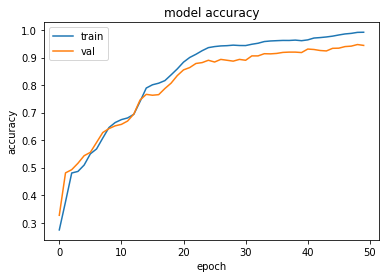

In [106]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [105]:
# model.save("author_lstm2_results")
from sklearn.metrics import confusion_matrix
import numpy as np

accuracy = model.evaluate(X_test, Y_test)
prediction = model.predict(X_test)
confusion_matrix = confusion_matrix(Y_test.argmax(axis=1), prediction.argmax(axis=1))
print(confusion_matrix)

print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accuracy[0],accuracy[1]))

ValueError: in user code:

    /Users/gracekim/opt/anaconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1233 test_function  *
        return step_function(self, iterator)
    /Users/gracekim/opt/anaconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1224 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/gracekim/opt/anaconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/gracekim/opt/anaconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/gracekim/opt/anaconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/gracekim/opt/anaconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1217 run_step  **
        outputs = model.test_step(data)
    /Users/gracekim/opt/anaconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1185 test_step
        self.compiled_loss(
    /Users/gracekim/opt/anaconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /Users/gracekim/opt/anaconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    /Users/gracekim/opt/anaconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /Users/gracekim/opt/anaconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/gracekim/opt/anaconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:1537 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /Users/gracekim/opt/anaconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/gracekim/opt/anaconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:4833 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /Users/gracekim/opt/anaconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 12) and (None, 20) are incompatible


### Transfer

In [85]:
from keras.models import load_model
pretext_model = load_model("author_lstm2_results")

In [86]:
from keras.models import Sequential
from keras import layers
from keras import callbacks

pretext_model.add(layers.Dense(12, activation='softmax'))
pretext_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
pretext_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 80, 50)            2342350   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 80, 50)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_12 (Dense)             (None, 20)                2020      
_________________________________________________________________
dense_13 (Dense)             (None, 12)                252       
Total params: 2,405,022
Trainable params: 2,405,022
Non-trainable params: 0
_________________________________________________________________


In [104]:
# Freeze the pre-trained layers

for layer in pretext_model.layers[:4]:
    layer.trainable=False

In [97]:
history = pretext_model.fit(X_train, Y_train, 
                    epochs=50, 
                    validation_data=(X_val, Y_val),
                    batch_size=25)

Epoch 1/50
605/605 [==============================] - 57s 90ms/step - loss: 2.2815 - accuracy: 0.2242 - val_loss: 2.0580 - val_accuracy: 0.3270
Epoch 2/50
605/605 [==============================] - 54s 90ms/step - loss: 2.0095 - accuracy: 0.3289 - val_loss: 1.7285 - val_accuracy: 0.4810
Epoch 3/50
605/605 [==============================] - 58s 96ms/step - loss: 1.6987 - accuracy: 0.4761 - val_loss: 1.5533 - val_accuracy: 0.4926
Epoch 4/50
605/605 [==============================] - 60s 99ms/step - loss: 1.5328 - accuracy: 0.4815 - val_loss: 1.3944 - val_accuracy: 0.5159
Epoch 5/50
605/605 [==============================] - 58s 96ms/step - loss: 1.4141 - accuracy: 0.5023 - val_loss: 1.3237 - val_accuracy: 0.5434
Epoch 6/50
605/605 [==============================] - 57s 95ms/step - loss: 1.2844 - accuracy: 0.5478 - val_loss: 1.2023 - val_accuracy: 0.5556
Epoch 7/50
605/605 [==============================] - 72s 119ms/step - loss: 1.1787 - accuracy: 0.5606 - val_loss: 1.1248 - val_accuracy

In [100]:
from sklearn.metrics import confusion_matrix
import numpy as np

accuracy = pretext_model.evaluate(X_test, Y_test)
prediction = pretext_model.predict(X_test)
confusion_matrix = confusion_matrix(Y_test.argmax(axis=1), prediction.argmax(axis=1))
print(confusion_matrix)

print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accuracy[0],accuracy[1]))

60/60 [==============================] - 1s 11ms/step - loss: 0.2741 - accuracy: 0.9465
[[287   0   0   1   1   0   2  10   0   0   0   0]
 [  0 613   0   0   0   0   0   0   0   0   0   0]
 [  0   1   0   2   0   0   0   0   0   1   0   3]
 [  0   0   0  54   0   1   2   1   0   0   0   0]
 [  0   0   0   1  17   0   0   0   0   0   0   0]
 [  0   0   0   0   0  30   0   1   0   0   0   0]
 [  1   0   0   3   0   0 230   5   1   0   0   5]
 [  6   0   0   0   1   0   5 190   1   0   0   2]
 [  0   0   0   4   0   1  15   2 175   0   0   9]
 [  0   0   0   0   0   0   0   0   0  29   0   3]
 [  0   0   0   0   1   0   0   0   0   0  95   0]
 [  0   0   0   3   1   0   2   0   0   3   0  68]]
Test set
  Loss: 0.274
  Accuracy: 0.947


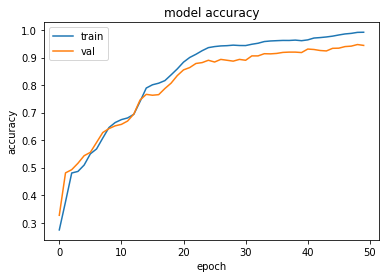

In [103]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Comparing Against Other Models

### Logistics Regression

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(text_train)
X_train = vectorizer.transform(text_train)
X_test  = vectorizer.transform(text_test)
X_val = vectorizer.transform(text_val)

In [ ]:
from sklearn.linear_model import LogisticRegression
from numpy import mean
from numpy import std
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

classifier = LogisticRegression(multi_class='multinomial', solver="lbfgs")
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(classifier, X_train, label_train, scoring='accuracy', cv=cv, n_jobs=-1)
# classifier.fit(X_train, Y_train)
# score = classifier.score(X_test, Y_test)
print("Accuracy:", mean(n_scores))

### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

gnb = GaussianNB().fit(X_train, label_train)
gnb_predictions = gnb.predict(X_test)

# accuracy
accuracy = gnb.score(X_test, label_test)
print(accuracy)

cm = confusion_matrix(label_test, gnb_predictions)
print(cm)

### Decision Tree Classifier 

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtree_model = DecisionTreeClassifier().fit(X_train, label_train)

dtree_predictions = dtree_model.predict(X_test)
accuracy = dtree_model.score(X_test, label_test)
print(accuracy)

cm = confusion_matrix(label_test, dtree_predictions)
print(cm)

### KNN (k-nearest-neighbors) classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 7).fit(X_train, label_train)

accuracy = knn.score(X_test, label_test)
print(accuracy)

knn_predictions=knn.predict(X_test)
cm = confusion_matrix(label_test, knn_predictions)
print(cm)